In [1]:
from jittor.utils.pytorch_converter import convert

pytorch_code="""
import torch.distributed as dist

"""

jittor_code = convert(pytorch_code)
print(jittor_code)

[i 0528 16:47:20.009214 40 log.cc:351] Load log_sync: 1
[i 0528 16:47:20.082018 40 compiler.py:956] Jittor(1.3.9.14) src: /home/xaMars/anaconda3/envs/jittor/lib/python3.7/site-packages/jittor
[i 0528 16:47:20.096117 40 compiler.py:957] g++ at /usr/bin/g++(9.4.0)
[i 0528 16:47:20.098092 40 compiler.py:958] cache_path: /home/xaMars/.cache/jittor/jt1.3.9/g++9.4.0/py3.7.12/Linux-5.15.0-1xe9/IntelRXeonRGolxc9/c208/default
[i 0528 16:47:20.157416 40 install_cuda.py:96] cuda_driver_version: [12, 2]
[i 0528 16:47:20.160982 40 install_cuda.py:82] needed restart but not /home/xaMars/anaconda3/envs/jittor/bin/python ['-m', 'ipykernel_launcher', '--f=/run/user/1002/jupyter/runtime/kernel-v307bef377542a1ba182efcf076c58bcdcd62ed4e8.json'], you can ignore this warning.
[i 0528 16:47:20.176816 40 __init__.py:412] Found /home/xaMars/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc(12.2.140) at /home/xaMars/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc.
[i 0528 16:47:20.265134 40 __init__.py:41


import jittor as jt
from jittor import init
from jittor import nn



In [ ]:
#下载数据集：
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

# 下载 CIFAR-100（放在当前目录的 `./data` 文件夹）
train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)



In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

# (1) MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# (2) Fashion-MNIST
fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# (3) CIFAR10
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# (4) SVHN
svhn_train = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# (5) NotMNIST（torchvision 不提供，需额外下载）
# 方法见下文


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [02:01<00:00, 81817.10it/s]  


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
<urlopen error [SSL: KRB5_S_TKT_NYV] unexpected eof while reading (_ssl.c:1091)>



RuntimeError: Error downloading train-labels-idx1-ubyte.gz

In [ ]:
import jittor as jt
import jittor.nn as nn
import math
import warnings
from typing import Optional, Callable, Any, Dict, Union, Tuple
import numpy as np

# ================================
# Helper Functions
# ================================

def named_apply(fn: Callable, module: nn.Module, name='', depth_first=True, include_root=False) -> nn.Module:
    """
    Apply a function to all submodules of a module, optionally including the root module itself.
    
    Args:
        fn: Function to apply to each module
        module: Root module
        name: Name of the root module
        depth_first: Whether to apply function depth-first
        include_root: Whether to apply function to root module
    """
    if not depth_first and include_root:
        fn(module=module, name=name)
    
    for child_name, child_module in module.named_children():
        child_full_name = '.'.join([name, child_name]) if name else child_name
        named_apply(fn=fn, module=child_module, name=child_full_name, 
                   depth_first=depth_first, include_root=True)
    
    if depth_first and include_root:
        fn(module=module, name=name)
    
    return module


def adapt_input_conv(in_chans, conv_weight):
    """
    Adapt a convolutional layer to a different number of input channels by 
    averaging or replicating weights.
    
    Args:
        in_chans: Number of input channels to adapt to
        conv_weight: Original convolutional weight tensor
    """
    conv_type = conv_weight.__class__
    O, I, J, K = conv_weight.shape
    
    if in_chans == 1:
        if I > 1:
            conv_weight = conv_weight.sum(dim=1, keepdim=True)
    elif in_chans != I:
        if I == 1:
            # Replicate single channel to multiple channels
            conv_weight = conv_weight.repeat(1, in_chans, 1, 1)
        else:
            # Average existing channels and then replicate
            conv_weight = conv_weight.sum(dim=1, keepdim=True)
            conv_weight = conv_weight.repeat(1, in_chans, 1, 1) / in_chans
    
    return conv_weight


def checkpoint_seq(functions, x, every=1, flatten=False, skip_last=False, preserve_rng_state=True):
    """
    A helper function for checkpointing sequential models.
    Jittor doesn't have gradient checkpointing like PyTorch, so we'll implement a basic version.
    """
    def run_function(start, end, functions):
        def forward(input):
            for j in range(start, end + 1):
                input = functions[j](input)
            return input
        return forward

    if isinstance(functions, jt.nn.Sequential):
        functions = list(functions)

    segment_size = every
    end = -1
    
    for start in range(0, len(functions), segment_size):
        end = min(start + segment_size - 1, len(functions) - 1)
        if skip_last and end == len(functions) - 1:
            # Run the last segment without checkpointing
            for j in range(start, len(functions)):
                x = functions[j](x)
        else:
            x = run_function(start, end, functions)(x)
    
    return x


def trunc_normal_(tensor, mean: float = 0., std: float = 1., a: float = -2., b: float = 2.):
    """
    Fills the input tensor with values drawn from a truncated normal distribution.
    
    Args:
        tensor: n-dimensional jittor.Var
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    """
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    def sample_truncated_normal(shape, mean, std, a, b):
        # Convert to standard normal bounds
        l = norm_cdf((a - mean) / std)  # lower bound
        u = norm_cdf((b - mean) / std)  # upper bound
        
        # Sample from uniform and convert to normal
        uniform_samples = np.random.uniform(l, u, shape)
        # Inverse CDF (approximate)
        normal_samples = np.sqrt(2) * np.array([math.erfinv(2 * u - 1) for u in uniform_samples.flatten()])
        normal_samples = normal_samples.reshape(shape)
        
        # Scale and shift
        return normal_samples * std + mean

    with jt.no_grad():
        values = sample_truncated_normal(tensor.shape, mean, std, a, b)
        tensor.assign(jt.array(values).astype(tensor.dtype))
    
    return tensor


# ================================
# Layer Implementations
# ================================

class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True):
        super().__init__()
        if isinstance(img_size, int):
            img_size = (img_size, img_size)
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def execute(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        x = self.proj(x)  # B, embed_dim, H', W'
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # B, N, embed_dim
        x = self.norm(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def execute(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def execute(self, x):
        if self.drop_prob == 0. or not self.is_training():
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        random_tensor = keep_prob + jt.rand(shape, dtype=x.dtype)
        random_tensor = jt.floor(random_tensor)  # binarize
        output = x.divide(keep_prob) * random_tensor
        return output

    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


# ================================
# Additional Utility Functions
# ================================

def init_weights_vit_timm(module: nn.Module, name: str = ''):
    """
    ViT weight initialization, original timm impl (for reproducibility)
    """
    if isinstance(module, nn.Linear):
        trunc_normal_(module.weight, std=.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    """
    Resize position embedding
    """
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = jt.nn.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    
    posemb = jt.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


# ================================
# Model Loading Utilities
# ================================

def load_pytorch_weights_to_jittor(jittor_model, pytorch_state_dict):
    """
    Load PyTorch state dict into Jittor model
    
    Args:
        jittor_model: Jittor model instance
        pytorch_state_dict: PyTorch state dict (can be loaded with torch.load)
    """
    jittor_state_dict = {}
    
    for name, param in pytorch_state_dict.items():
        if isinstance(param, np.ndarray):
            jittor_param = jt.array(param)
        else:
            # Assume it's a torch tensor, convert to numpy first
            try:
                jittor_param = jt.array(param.detach().cpu().numpy())
            except:
                jittor_param = jt.array(param)
        
        jittor_state_dict[name] = jittor_param
    
    # Load state dict into jittor model
    jittor_model.load_state_dict(jittor_state_dict)
    return jittor_model


def convert_pytorch_checkpoint(pytorch_ckpt_path, jittor_model):
    """
    Convert PyTorch checkpoint to Jittor model
    
    Args:
        pytorch_ckpt_path: Path to PyTorch checkpoint file
        jittor_model: Jittor model to load weights into
    """
    try:
        import torch
        checkpoint = torch.load(pytorch_ckpt_path, map_location='cpu')
        
        # Handle different checkpoint formats
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint
        
        return load_pytorch_weights_to_jittor(jittor_model, state_dict)
    
    except ImportError:
        print("PyTorch not available. Please provide state_dict as numpy arrays or jittor arrays.")
        return None
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

In [1]:
# 加载pkl文件
import pickle
with open('/home/xaMars/wjr_py/l2pJittor/l2p-jittor-main/output/checkpoint/task1_checkpoint.pkl', 'rb') as f:
    data = pickle.load(f)

[i 0608 10:37:36.819385 92 log.cc:351] Load log_sync: 1
[i 0608 10:37:36.892593 92 compiler.py:956] Jittor(1.3.9.14) src: /home/xaMars/anaconda3/envs/jittor/lib/python3.7/site-packages/jittor
[i 0608 10:37:36.906679 92 compiler.py:957] g++ at /usr/bin/g++(9.4.0)
[i 0608 10:37:36.908237 92 compiler.py:958] cache_path: /home/xaMars/.cache/jittor/jt1.3.9/g++9.4.0/py3.7.12/Linux-5.15.0-1xe9/IntelRXeonRGolxc9/c208/default
[i 0608 10:37:36.962554 92 install_cuda.py:96] cuda_driver_version: [12, 2]
[i 0608 10:37:36.967173 92 install_cuda.py:82] needed restart but not /home/xaMars/anaconda3/envs/jittor/bin/python ['-m', 'ipykernel_launcher', '--f=/run/user/1002/jupyter/runtime/kernel-v3116ec25ebd405a2a4678cf6ee12505fb1804b1c4.json'], you can ignore this warning.
[i 0608 10:37:36.985403 92 __init__.py:412] Found /home/xaMars/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc(12.2.140) at /home/xaMars/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc.
[i 0608 10:37:37.090191 92 __init__.py:41

In [1]:
import numpy as np
# 读取文件（自动识别 .npy 格式）
data = np.load('/home/xaMars/wjr_py/l2pJittor/l2p-jittor-main/output_five/mnist_task_list_arr.npy')  

In [2]:
data.shape

(1, 5, 7500, 3)

In [3]:
data=data.reshape(-1,3)

In [4]:
data.shape

(37500, 3)

NameError: name 'i' is not defined

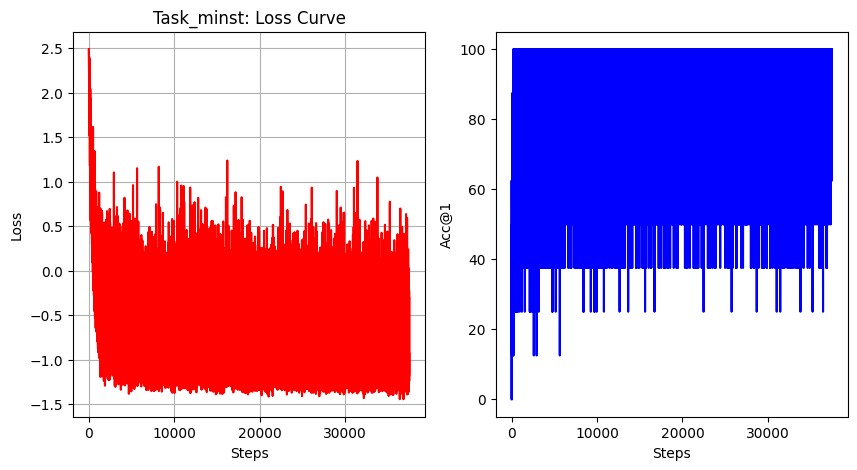

In [6]:
import numpy as np
import matplotlib.pyplot as plt



# 创建 10 张图（每张图包含 loss 和 acc1 曲线）

plt.figure(figsize=(10, 5))

# 提取第 i 组数据的 loss 和 acc1
steps = np.arange(data.shape[0])  # x 轴步数
loss = data[:, 0]     # loss 值
acc1 = data[:, 1]     # acc1 值
loss_sample = loss[::10]         # loss[0], loss[10], loss[20], ...
acc1_sample = acc1[::10]         # acc1[0], acc1[10], acc1[20], ...

# 绘制 loss 曲线（左 y 轴）
plt.subplot(1, 2, 1)
plt.plot(steps, loss, 'r-', label='Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'Task_minst: Loss Curve')
plt.grid()

# 绘制 acc1 曲线（右 y 轴）
plt.subplot(1, 2, 2)
plt.plot(steps, acc1, 'b-', label='Acc1')
plt.xlabel('Steps')
plt.ylabel('Acc@1')
plt.title(f'Experiment {i+1}: Acc@1Curve')
plt.grid()

plt.tight_layout()
plt.show()  # 显示当前图（或保存到文件）
    # plt.savefig(f'/home/xaMars/wjr_py/l2pJittor/l2p-jittor-main/output/figure/train_task_{i+1}_loss_acc.png')
